
# PET TOF sinogram projector

In this example we will show how to setup and use a TOF PET sinogram projector
consisting of a geometrical TOF forward projector (Joseph's method), 
a resolution model and a correction for attenuation.

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [1]:
# import array_api_compat.numpy as xp

import array_api_compat.cupy as xp
# import array_api_compat.torch as xp
import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
import os

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    dev = "cuda"


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /home/pablo/.conda/envs/recon/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /home/pablo/.conda/envs/recon/lib/libparallelproj_cuda.so.1.8.0
    


setup a regular polygon PET scanner



In [2]:
# Tailored to Biograph Vision Quadra System (Performance Characteristics of the Biograph Vision Quadra PET/CT System with a Long Axial Field of View Using the NEMA NU 2-2018 Standard)
num_rings = 150 # 322, reduced to fit in GPU
original_max_z = 530  # millimeters
original_min_z = -original_max_z 
axial_ring_distance = (original_max_z - original_min_z) / (num_rings + 1)
radius = 410.0  # millimeters
max_z = 150
min_z = -max_z
ring_positions = xp.arange(min_z, max_z, axial_ring_distance)

print("number of rings is ", len(ring_positions))

scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=radius,
    num_sides=38,
    num_lor_endpoints_per_side=10, ###20, reduced to reduce memory usage
    lor_spacing=6.4,  # 3.2, lor_spacing to match num_lor_endpoints_per_side
    ring_positions=ring_positions,
    symmetry_axis=1,
)

number of rings is  43


setup the LOR descriptor that defines the sinogram



In [3]:
lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=3,
    max_ring_difference=1,
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)

## Defining a non-TOF projector

:class:`.RegularPolygonPETProjector` can be used to define a non-TOF projector
that combines the scanner, LOR and image geometry. The latter is defined by
the image shape, the voxel size, and the image origin.



In [4]:
# define a first projector using an image with 160x32x32 voxels of size 1x2x2 mm
# where the image center is at world coordinate (0, 0, 0)
img_shape = (350, 250 // 2, 200 // 2)
proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=img_shape, voxel_size=(1.0, 2.0, 2.0)
)

## Visualize the scanner and image geometry

:meth:`.RegularPolygonPETProjector.show_geometry` can be used
to visualize the scanner and image geometry



/tmp/ipykernel_2110701/2191495055.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


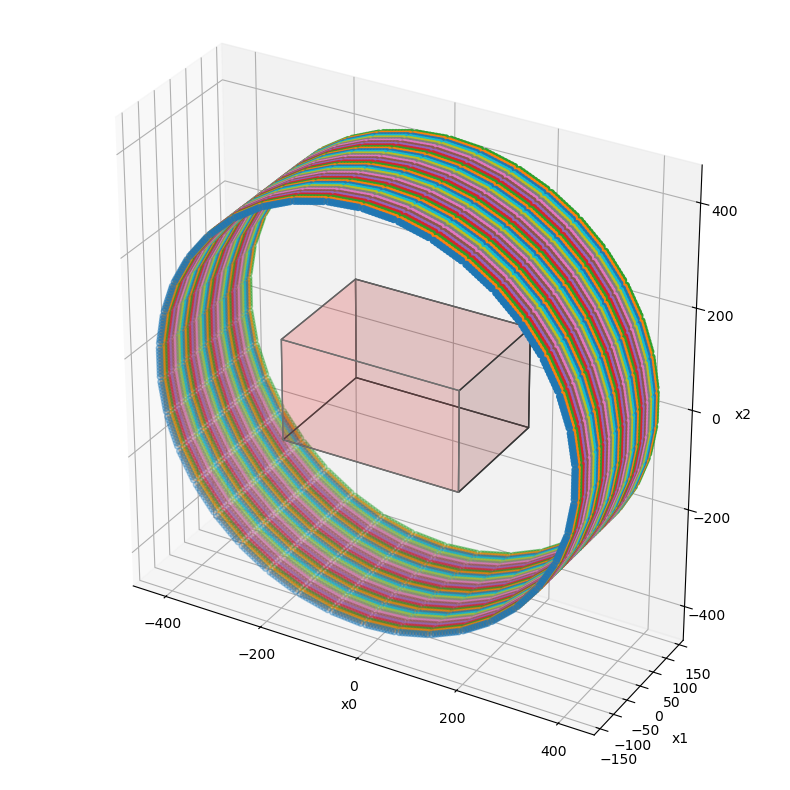

In [5]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection="3d")
proj.show_geometry(ax1)
# ax1.view_init(elev=0, azim=0)
fig.tight_layout()
fig.show()

## Adding an image-based resolution model



In [6]:
# setup a simple image-based resolution model with an Gaussian FWHM of 4.5mm (Table 2: https://jnm.snmjournals.org/content/63/3/476.long)
res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma= 3.5 / (2. * proj.voxel_size)
)

## Calculation of the non-TOF attenuation sinogram



In [7]:
print("GB used at cell start: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

# setup an attenuation (mu, units in 1/mm) image containing the attenuation coeff
mu_pet_water = 0.0096
mu_pet_bone = 0.0172
mu_ct_water = 0.0184
mu_ct_bone = 0.0428
CT = xp.load("/home/pablo/prototwin/deep-learning-dose-activity-dictionary/data/sobp-dataset6/CT.npy")

def CT_to_attenuation(CT):
    CT_smaller_zero = mu_pet_water * (CT + 1000) / 1000
    CT_larger_zero = mu_pet_water + CT * mu_ct_water * (mu_pet_bone - mu_pet_water) / 1000 / (mu_ct_bone - mu_pet_water)
    mask = CT > 0
    mu_PET = xp.where(mask, CT_larger_zero, CT_smaller_zero)
    return mu_PET

x_att = CT_to_attenuation(CT)

del CT

# x_att = xp.full(proj.in_shape, mu_pet_water, device=dev, dtype=xp.float32)  # to get a uniform attenuation

# forward project the attenuation image
x_att_fwd = proj(x_att)

del x_att

# calculate the attenuation sinogram
att_sino = xp.exp(-x_att_fwd)

del x_att_fwd

print("GB used at cell start: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

GB used at cell start:  0.0011067390441894531
GB used at cell start:  0.23707246780395508


## Adding time-of-flight to the projector



In [8]:
TOFps = 225
tofbin_FWHM = TOFps * 1e-12 * 3e8 / 2 *1e3 # *1e3 to mm;  *1e-12 to s; *3e8 to m/s;  /2 to get one-way distance;
sigma_tof = tofbin_FWHM / 2.355 # / 2.355 to get sigma from FWHM
tofbin_width = 1.03 * sigma_tof  # as given in https://parallelproj.readthedocs.io/en/stable/python_api.html#module-parallelproj.tof
num_tofbins = int(2 * radius // tofbin_width)
if num_tofbins % 2 == 0:
    num_tofbins -= 1
print("num_tofbins", num_tofbins)

proj.tof_parameters = parallelproj.TOFParameters(tofbin_width=tofbin_width, sigma_tof=sigma_tof, num_tofbins=num_tofbins)  # TOF resolution of 225 ps

num_tofbins 55


## Combining resolution model, TOF projector and attenuation model

Since the attenuation sinogram is a non-TOF sinogram with shape = (a, b, c) and
the output of the projector is a TOF sinogram with shape = (a, b, c num_tofbins),
we have to use the :class:`.TOFNonTOFElementwiseMultiplicationOperator` to add the
attenuation model to the forward model.



In [9]:
print(f"atten. sino shape {att_sino.shape}")
print(f"proj output shape {proj.out_shape}")

att_op = parallelproj.TOFNonTOFElementwiseMultiplicationOperator(
    proj.out_shape, att_sino
)

# setup a forward projector containing the attenuation and resolution
proj_with_att_and_res_model = parallelproj.CompositeLinearOperator(
    (att_op, proj, res_model)
)


atten. sino shape (375, 190, 127)
proj output shape (375, 190, 127, 55)


## Import the activation image


In [10]:
print("GB used at cell start: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB
# Initial and final time of PET measurements
initial_time = 10  # minutes
final_time = 40 # minutes

dtype = np.float32
npy_location = os.path.join("/home/pablo/prototwin/deep-learning-dose-activity-dictionary/data/sobp-dataset6/input")

activation = np.load(npy_location + "/sobp0.npy")
activation = activation.astype(int)
activation = xp.asarray(activation, dtype=dtype)
activation = to_device(activation, dev)
print("GB used at cell end: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

GB used at cell start:  0.23707246780395508
GB used at cell end:  0.2533707618713379


In [11]:
print("GB used at cell start: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB
# Getting the sinogram y, applying scanner sensitivity and adding Poisson noise

y = proj_with_att_and_res_model(activation)  # sinogram

sensitivity = 0.05 # %, scanner sensitivity
y =  y * sensitivity * xp.sum(activation) / xp.sum(y)

# add Poisson noise
y = xp.asarray(
    xp.random.poisson(y),
    device=dev,
    dtype=dtype,
)
print("GB used at cell end: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

GB used at cell start:  0.2533707618713379
GB used at cell end:  2.1073780059814453


In [12]:
# EM function (for OSEM and MLEM)

def em_update(x_cur, data, op, adjoint_ones):
    """EM update
    Parameters
    ----------
    x_cur : Array
        current solution
    data : Array
        data
    op : parallelproj.LinearOperator
        linear forward operator
    adjoint_ones : Array
        adjoint of ones
    """
    epsilon = 1e-10  #  If ybar contains zeros, dividing by it can produce NaNs
    ybar = op(x_cur)
    return x_cur * op.adjoint(data / (ybar + epsilon)) / adjoint_ones
 

In [13]:
# print("GB used at cell start: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

# # Applying MLEM
# # number of MLEM iterations
# num_iter = 30

# # initialize x
# x = xp.ones(proj_with_att_and_res_model.in_shape, dtype=xp.float32, device=dev)
# # calculate A^H 1
# adjoint_ones = proj_with_att_and_res_model.adjoint(
#     xp.ones(proj_with_att_and_res_model.out_shape, dtype=xp.float32, device=dev)
# )

# x_list = []
# for i in range(num_iter):
#     print(f"MLEM iteration {(i + 1):03} / {num_iter:03}", end="\r")
#     x = em_update(x, y, proj_with_att_and_res_model, adjoint_ones)
#     if xp.all(xp.isnan(x)): break
#     x_list.append(x.get())
    
    
# print("GB used at cell end: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

In [14]:
print("GB used at cell start: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB
from copy import copy

# Applying OSEM
num_subsets = 10

subset_views, subset_slices = proj.lor_descriptor.get_distributed_views_and_slices(
    num_subsets, len(proj.out_shape)
)

_, subset_slices_non_tof = proj.lor_descriptor.get_distributed_views_and_slices(
    num_subsets, 3
)


# clear the cached LOR endpoints since we will create many copies of the projector
proj.clear_cached_lor_endpoints()
pet_subset_linop_seq = []

# we setup a sequence of subset forward operators each constisting of
# (1) image-based resolution model
# (2) subset projector
# (3) multiplication with the corresponding subset of the attenuation sinogram
for i in range(num_subsets):
    print(f"subset {i:02} containing views {subset_views[i]}")

    # make a copy of the full projector and reset the views to project
    subset_proj = copy(proj)
    subset_proj.views = subset_views[i]

    subset_att_op = parallelproj.TOFNonTOFElementwiseMultiplicationOperator(
        subset_proj.out_shape, att_sino[subset_slices_non_tof[i]]
    )

    # add the resolution model and multiplication with a subset of the attenuation sinogram
    pet_subset_linop_seq.append(
        parallelproj.CompositeLinearOperator(
            [
                subset_att_op,
                subset_proj,
                res_model,
            ]
        )
    )

pet_subset_linop_seq = parallelproj.LinearOperatorSequence(pet_subset_linop_seq)

# number of OSEM iterations
num_iter = 3
print(len(pet_subset_linop_seq), num_subsets)
print("num_iter = ", num_iter)

# initialize x
x = xp.ones(proj_with_att_and_res_model.in_shape, dtype=xp.float64, device=dev)

# calculate A_k^H 1 for all subsets k
subset_adjoint_ones = [
    x.adjoint(xp.ones(x.out_shape, dtype=xp.float64, device=dev))
    for x in pet_subset_linop_seq
]


x_list = []
 # OSEM iterations
for i in range(num_iter):
    for k, sl in enumerate(subset_slices):
        print(f"OSEM iteration {(k+1):03} / {(i + 1):03} / {num_iter:03}", end="\r")
        x = em_update(
            x, y[sl], pet_subset_linop_seq[k], subset_adjoint_ones[k]
        )
        if xp.any(xp.isnan(x)): break
        x_list.append(x.get())

print("GB used at cell end: ", xp.get_default_memory_pool().used_bytes() / 2**30)  # Current used GB

GB used at cell start:  2.1073780059814453
subset 00 containing views [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180]
subset 01 containing views [  5  15  25  35  45  55  65  75  85  95 105 115 125 135 145 155 165 175
 185]
subset 02 containing views [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181]
subset 03 containing views [  6  16  26  36  46  56  66  76  86  96 106 116 126 136 146 156 166 176
 186]
subset 04 containing views [  2  12  22  32  42  52  62  72  82  92 102 112 122 132 142 152 162 172
 182]
subset 05 containing views [  7  17  27  37  47  57  67  77  87  97 107 117 127 137 147 157 167 177
 187]
subset 06 containing views [  3  13  23  33  43  53  63  73  83  93 103 113 123 133 143 153 163 173
 183]
subset 07 containing views [  8  18  28  38  48  58  68  78  88  98 108 118 128 138 148 158 168 178
 188]
subset 08 containing views [  4  14  24  34  44  54  64  74  84  94 104 114 124 134 144 154 164 174
 184]
sub

## forward and back project the image



In [15]:
# Simple backpropagation, no iterative reconstruction

# x_fwd = proj_with_att_and_res_model(x)
# x_fwd_back = proj_with_att_and_res_model.adjoint(x_fwd)
# print(x_fwd.shape)

## visualize the reconstructed and the original image



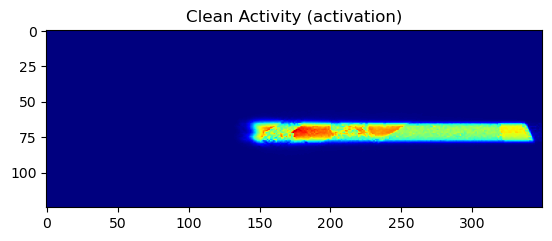

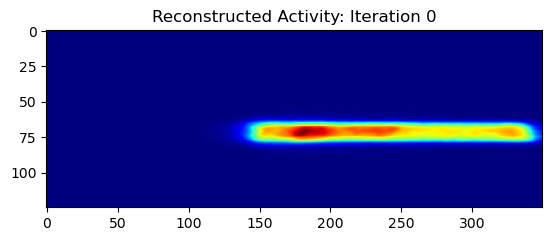

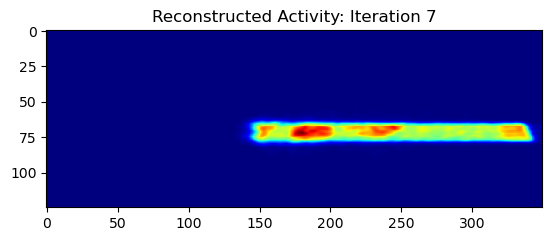

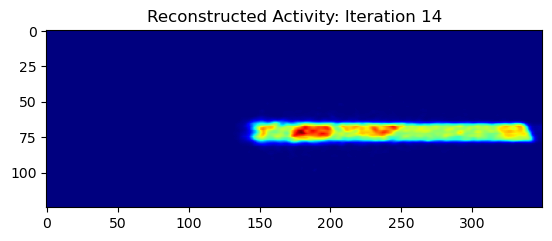

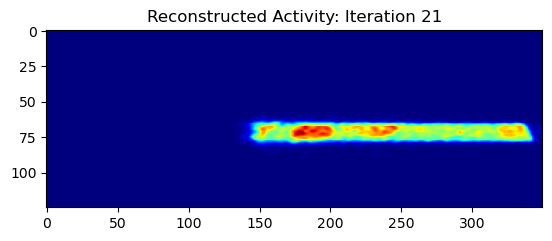

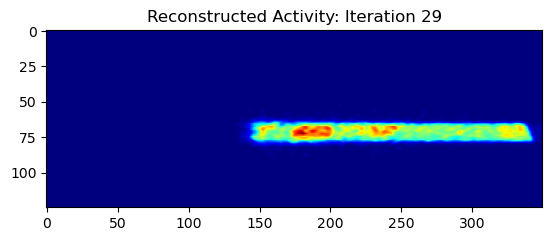

In [16]:
# plt.figure()
# y_slice = x.shape[1] // 2
# plt.imshow(x.get()[:, y_slice, :].T, cmap="jet")

# Plot the activity image above and the x image below
z_slice = activation.shape[2] // 2 + 10

activation_normalized = (activation.get() - activation.get().min()) / (activation.get().max() - activation.get().min())

plt.figure()
plt.imshow(activation_normalized[:, :, z_slice].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[:, :, z_slice].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

Best MSE at iteration 21 with value 4.694103677564852e-05
Best SSIM at iteration 16 with value 0.9135386668110497
Best PSNR at iteration 21 with value 43.28447322471328
Elbow point is at iteration 3 with metric value 9.261556526929529e-05
Elbow point is at iteration 4 with metric value 0.9105821601182799
Elbow point is at iteration 5 with metric value 42.13969356215814


Text(0, 0.5, 'Metrics')

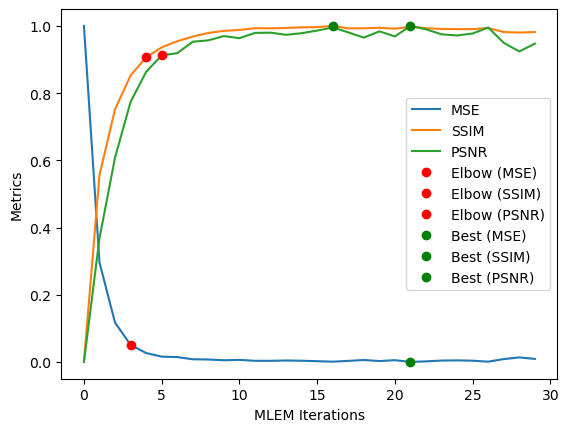

In [17]:
# Find elbow
from skimage.metrics import structural_similarity as ssim

def mse_loss(array1, array2):
    return np.mean((array1 - array2) ** 2)# Find elbow
def mae_loss(array1, array2):
    return np.mean(np.abs(array1 - array2))
def psnr_loss(array1, array2):
    mse = mse_loss(array1, array2)
    if mse == 0:
        return float('inf')
    max_pixel = array1.max()  # Adjust based on your image data range
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

mse_loss_array = []
ssim_loss_array = []
psnr_loss_array = []


for i, x in enumerate(x_list):
    x_normalized = (x - x.min()) / (x.max() - x.min())
    mse_loss_array.append(mse_loss(x_normalized, activation_normalized))
    ssim_loss_array.append(ssim(x_normalized, activation_normalized, data_range=1.0))
    psnr_loss_array.append(psnr_loss(x_normalized, activation_normalized))

mse_loss_array = np.array(mse_loss_array)
ssim_loss_array = np.array(ssim_loss_array)
psnr_loss_array = np.array(psnr_loss_array)

# Print best metric iterations
best_mse = np.argmin(mse_loss_array)
print(f"Best MSE at iteration {best_mse} with value {mse_loss_array[best_mse]}")
best_ssim = np.argmax(ssim_loss_array)
print(f"Best SSIM at iteration {best_ssim} with value {ssim_loss_array[best_ssim]}")
best_psnr = np.argmax(psnr_loss_array)
print(f"Best PSNR at iteration {best_psnr} with value {psnr_loss_array[best_psnr]}")

# Print elbow 
# Function to calculate distance from a point to a line (given by two points)
def point_line_distance(point, line_start, line_end):
    return np.abs(np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
mlem_iterations = np.arange(len(x_list))
#MSE
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], mse_loss_array[0]])
line_end = np.array([mlem_iterations[-1], mse_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, mse_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_mse= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_mse} with metric value {mse_loss_array[elbow_mse]}")
#SSIM
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], ssim_loss_array[0]])
line_end = np.array([mlem_iterations[-1], ssim_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, ssim_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_ssim= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_ssim} with metric value {ssim_loss_array[elbow_ssim]}")
#PSNR
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], psnr_loss_array[0]])
line_end = np.array([mlem_iterations[-1], psnr_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, psnr_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_psnr= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_psnr} with metric value {psnr_loss_array[elbow_psnr]}")

mse_loss_array = (mse_loss_array - mse_loss_array.min()) / (mse_loss_array.max() - mse_loss_array.min())
ssim_loss_array = (ssim_loss_array - ssim_loss_array.min()) / (ssim_loss_array.max() - ssim_loss_array.min())
psnr_loss_array = (psnr_loss_array - psnr_loss_array.min()) / (psnr_loss_array.max() - psnr_loss_array.min())

# Plot the metrics
plt.figure()
plt.plot(mlem_iterations, mse_loss_array, label="MSE")
plt.plot(mlem_iterations, ssim_loss_array, label="SSIM")
plt.plot(mlem_iterations, psnr_loss_array, label="PSNR")
# Plot the elbow
plt.plot(elbow_mse, mse_loss_array[elbow_mse], 'ro', label="Elbow (MSE)")
plt.plot(elbow_ssim, ssim_loss_array[elbow_ssim], 'ro', label="Elbow (SSIM)")
plt.plot(elbow_psnr, psnr_loss_array[elbow_psnr], 'ro', label="Elbow (PSNR)")
#Plot the best metrics
plt.plot(best_mse, mse_loss_array[best_mse], 'go', label="Best (MSE)")
plt.plot(best_ssim, ssim_loss_array[best_ssim], 'go', label="Best (SSIM)")
plt.plot(best_psnr, psnr_loss_array[best_psnr], 'go', label="Best (PSNR)")
plt.legend()
plt.xlabel("MLEM Iterations")
plt.ylabel("Metrics")

In [18]:
!jupyter nbconvert --to script visual_reconstruction_parallelproj.ipynb


[NbConvertApp] Converting notebook visual_reconstruction_parallelproj.ipynb to script
[NbConvertApp] Writing 16696 bytes to visual_reconstruction_parallelproj.py
